In [66]:
import os
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
from glob import glob
from PIL import Image
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import random_split, Dataset, DataLoader
import torchvision
from torchvision import transforms as T
import timm

from colorama import Fore, Style

CLR = (Fore.BLACK) if False else (Style.BRIGHT + Fore.WHITE)
RED = Style.BRIGHT + Fore.RED
BLUE = Style.BRIGHT + Fore.BLUE
CYAN = Style.BRIGHT + Fore.CYAN

# Matplotlib & Seaborn settings.
FONT_COLOR = "#000"
BACKGROUND_COLOR = "#F6F5F5"
DF_CMAP = sns.light_palette("#252131", as_cmap=True)
MY_RC = {
    "axes.labelcolor": FONT_COLOR,
    "axes.labelsize": 10,
    "axes.labelpad": 15,
    "axes.labelweight": "bold",
    "axes.titlesize": 14,
    "axes.titleweight": "bold",
    "axes.titlepad": 15,
    "xtick.labelsize": 7,
    "xtick.color": FONT_COLOR,
    "ytick.labelsize": 7,
    "ytick.color": FONT_COLOR,
    "figure.titlesize": 14,
    "figure.titleweight": "bold",
    "figure.facecolor": BACKGROUND_COLOR,
    "figure.edgecolor": BACKGROUND_COLOR,
    "figure.dpi": 72,  # Locally Seaborn uses 72, meanwhile Kaggle 96.
    "font.size": 14,
    "font.family": "Serif",
    "text.color": FONT_COLOR,
}

sns.color_palette("hls", 8)
sns.set_theme(rc=MY_RC)

In [68]:
class CustomDataset(Dataset):
    """
    Custom dataset for loading images from a directory structure where each subdirectory represents a class.
    The class directories should contain image files with a 'jpg' extension.

    Args:
        root (str): Root directory path containing class subdirectories with image files.
        transform (callable, optional): A function/transform that takes in an image and returns a transformed version.
                                        Default is None, meaning no transformation is applied.

    Attributes:
        transform (callable): The transform to be applied on images.
        im_paths (list): List of image file paths in the dataset.
        cls_names (dict): Dictionary mapping class names to integer labels.
        cls_counts (dict): Dictionary holding the count of images for each class.
    """
    def __init__(self, root, transform=None):

        self.transform = transform
        self.im_paths = [im_path for im_path in sorted(glob(f"{root}/*/*jpg"))]
        self.cls_names, self.cls_counts, count, data_count = {}, {}, 0, 0
        
        for idx, im_path in enumerate(self.im_paths):
            class_name = self.get_class(im_path)
            if class_name not in self.cls_names:
                self.cls_names[class_name] = count
                self.cls_counts[class_name] = 1
                count += 1
            else:
                self.cls_counts[class_name] += 1

    def get_class(self, path):
        return os.path.dirname(path).split("/")[-1]

    def __len__(self):
        return len(self.im_paths)

    def __getitem__(self, idx):

        im_path = self.im_paths[idx]
        im = Image.open(im_path).convert("RGB")
        gt = self.cls_names[self.get_class(im_path)]

        if self.transform is not None:
            im = self.transform(im)

        return im, gt



def get_dls(root: str, batch_size: int, transform=None, split=[0.9, 0.05, 0.05], num_workers=0):
    """
    Creates DataLoaders for training, validation, and testing from a dataset located at the 
    specified root directory.The dataset is expected to be organized such that each class is in a 
    separate subdirectory.

    Returns:
        tuple: Contains three DataLoader objects for the training, validation, and testing splits 
            of the dataset, and a dictionary mapping class names to class indices.
    """

    dataset = CustomDataset(root=root, transform=transform)

    total_len = len(dataset)
    train_len = int(total_len * split[0])
    val_len = int(total_len * split[1])
    test_len = total_len - (train_len + val_len)

    train_dataset, val_dataset, test_dataset = random_split(dataset=dataset, lengths=[train_len, val_len, test_len])

    train_loader, val_loader, test_loader = (
        DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers),
        DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers),
        DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=num_workers),
    )

    return train_loader, val_loader, test_loader, dataset.cls_names


In [69]:
on_kaggle = os.getenv("KAGGLE_KERNEL_RUN_TYPE") is not None
if on_kaggle:
    ROOT = "/kaggle/input/vehicles-image-dataset/vehicle_data"
else:
    ROOT = "data"


# Hyper Parameters    
BATCH_SIZE = 64
mean, std, im_size = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 224
TRANSFORM = T.Compose(
    [T.Resize((im_size, im_size)), T.ToTensor(), T.Normalize(mean=mean, std=std)]
)

train_loader, val_loader, test_loader, classes = get_dls(root=ROOT, batch_size=BATCH_SIZE, transform=TRANSFORM)

print(f"{CLR}len train_loader: {RED}{len(train_loader)}{CLR}, Items: {RED}{len(train_loader) * BATCH_SIZE}")
print(f"{CLR}len val_loader: {RED}{len(val_loader)}{CLR}, Items: {RED}{len(val_loader) * BATCH_SIZE}{CLR}")
print(classes)

len train_loader: 44, Items: 2816
len val_loader: 3, Items: 192
{'airplane': 0, 'ambulance': 1, 'bicycle': 2, 'boat': 3, 'bus': 4, 'car': 5, 'fire_truck': 6, 'helicopter': 7, 'hovercraft': 8, 'jet_ski': 9, 'kayak': 10, 'motorcycle': 11, 'rickshaw': 12, 'scooter': 13, 'segway': 14, 'skateboard': 15, 'tractor': 16, 'truck': 17, 'unicycle': 18, 'van': 19}


In [ ]:
def tensor_2_im(t, t_type="rgb"):
    """
    Converts a tensor image to a numpy image, optionally converting from 
    grayscale or RGB format.
    """

    gray_transforms = T.Compose(
        [T.Normalize(mean=[0.0], std=[1 / 0.5]), T.Normalize(mean=[-0.5], std=[1])]
    )
    rgb_transforms = T.Compose(
        [
            T.Normalize(mean=[0.0, 0.0, 0.0], std=[1 / 0.229, 1 / 0.224, 1 / 0.225]),
            T.Normalize(mean=[-0.485, -0.456, -0.406], std=[1.0, 1.0, 1.0]),
        ]
    )

    invTransform = gray_transforms if t_type == "gray" else rgb_transforms

    return (
        (invTransform(t) * 255)
        .detach()
        .squeeze()
        .cpu()
        .permute(1, 2, 0)
        .numpy()
        .astype(np.uint8)
        if t_type == "gray"
        else (invTransform(t) * 255)
        .detach()
        .cpu()
        .permute(1, 2, 0)
        .numpy()
        .astype(np.uint8)
    )


def visualize(data, n_ims, rows, cmap=None, cls_names=None):
    """
    Visualizes a subset of images from the dataset with their ground truth labels.
    """
    
    assert cmap in [
        "rgb",
        "gray",
    ], "Rasmni oq-qora yoki rangli ekanini aniqlashtirib bering!"
    if cmap == "rgb":
        cmap = "viridis"

    plt.figure(figsize=(18, 8))
    indexlar = [random.randint(0, len(data) - 1) for _ in range(n_ims)]
    for idx, index in enumerate(indexlar):

        im, gt = data[index]
        # Start plot
        plt.subplot(rows, n_ims // rows, idx + 1)
        if cmap:
            plt.imshow(tensor_2_im(im, cmap), cmap=cmap)
        else:
            plt.imshow(tensor_2_im(im))
        plt.axis("off")
        if cls_names is not None:
            plt.title(f"{cls_names[int(gt)]}")
        else:
            plt.title(f"{gt}")


visualize(train_loader.dataset, 20, 4, "rgb", list(classes.keys()))

/tmp/ipykernel_34/875978153.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(cls_names, rotation=60)


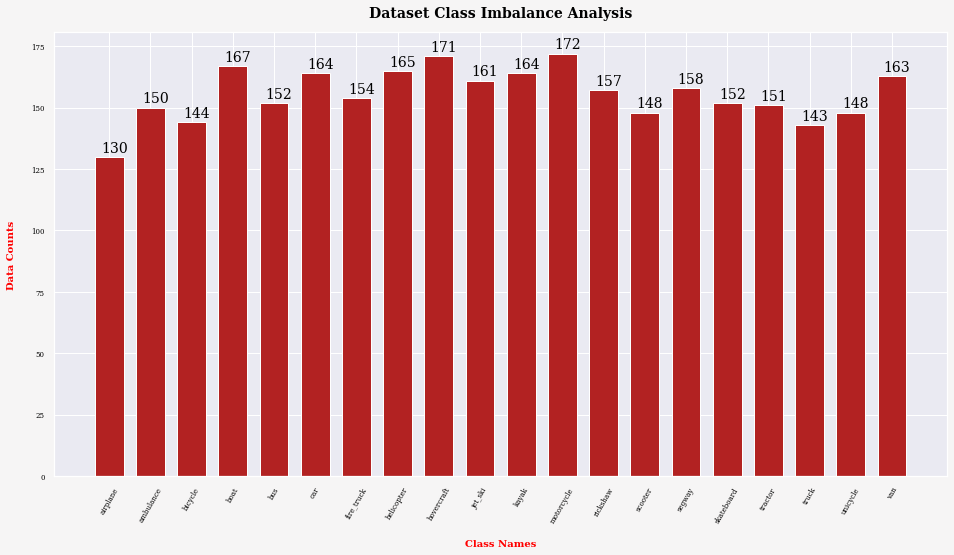

In [71]:
def data_analysis(root, transform):
    """
    Visualizes the class distribution within a dataset by plotting the number
    of instances for each class. This can help identify class imbalances.
    """
    dataset = CustomDataset(root=root, transform=transform)
    cls_counts, width, text_width = dataset.cls_counts, 0.7, 0.2
    text_height = 2
    cls_names = list(cls_counts.keys())
    counts = list(cls_counts.values())

    fig, ax = plt.subplots(figsize=(16, 8))
    indices = np.arange(len(counts))

    ax.bar(indices, counts, width, color="firebrick")
    ax.set_xlabel("Class Names", color="red")
    ax.set_xticklabels(cls_names, rotation=60)
    ax.set(xticks=indices, xticklabels=cls_names)
    ax.set_ylabel("Data Counts", color="red")
    ax.set_title(f"Dataset Class Imbalance Analysis")

    for i, v in enumerate(counts):
        ax.text(i - text_width, v + text_height, str(v), color="black")


data_analysis(root=ROOT, transform=TRANSFORM)

# `Model`

In [72]:
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)


if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using device: {device}")
    print(torch.cuda.get_device_name(0))

elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print(f"Using device: {device}")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

PyTorch version: 2.1.2
Torchvision version: 0.16.2
Using device: cuda
Tesla P100-PCIE-16GB


In [80]:
def get_metrics(
    model,
    inputs,
    labels,
    criterion,
    epoch_loss,
    epoch_acc
):
    preds = model(inputs)
    loss = criterion(preds, labels)
    return (
        loss,
        epoch_loss + (loss.item()),
        epoch_acc + (torch.argmax(preds, dim=1) == labels).sum().item(),
    )

def train_weights(
    data_loaders,
    model,
    optimizer,
    criterion,
    scheduler,
    epochs=10,
):
    
    since = time.time()
    train_loader , val_loader = data_loaders['train'], data_loaders['val']
      
    best_acc, best_loss, threshold, not_improved, patience = 0.0, float(torch.inf), 0.01, 0, 3
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    save_prefix, save_dir, sched = "vehicles", "saved_models", False
    print(f"{CLR}Start training...")
    
    for epoch in range(epochs):
        
        # ----- Train -----
        model.train()
        epoch_loss, epoch_acc = 0.0, 0.0
        n_total_steps = len(data_loaders['train'])
        
        for i, (inputs, labels) in enumerate(train_loader):

            inputs, labels = inputs.to(device), labels.to(device)

            loss, epoch_loss, epoch_acc = get_metrics(
                model, inputs, labels, criterion, epoch_loss, epoch_acc
            )
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if sched:
            scheduler.step()
            try:
                current_lr = optimizer.param_groups[0]['lr']
                print(f"{CYAN}Current learning rate is: {current_lr}")
            except:
                print("can't say current lr_rate")
            
        
        train_loss_to_track = epoch_loss / len(train_loader)
        train_acc_to_track = epoch_acc / len(train_loader.dataset)
        train_losses.append(train_loss_to_track)
        train_accs.append(train_acc_to_track)
        
        print(
            f"{CLR}Train: {RED}Epoch {CLR}[{epoch+1}/{epochs}], {RED}Step {CLR}[{i+1}/{n_total_steps}], {RED}Loss: {BLUE}{train_loss_to_track:.3f}, {RED}Acc: {BLUE}{train_acc_to_track:.3f}"
        )


        # ----- Validation -----
        model.eval()
        
        with torch.no_grad():
            val_epoch_loss, val_epoch_acc = 0, 0
            n_total_steps = len(data_loaders['val'])
            
            for idx, (inputs, labels) in enumerate(val_loader):
                inputs, labels = inputs.to(device) , labels.to(device)

                preds = model(inputs)
                loss = criterion(preds, labels)
                pred_cls = torch.argmax(preds.data, dim=1)
                val_epoch_acc += (pred_cls == labels).sum().item()
                val_epoch_loss += loss.item()

            val_loss_to_track = val_epoch_loss / len(val_loader)
            val_acc_to_track = val_epoch_acc / len(val_loader.dataset)
            val_losses.append(val_loss_to_track)
            val_accs.append(val_acc_to_track)

            
            print(
                f"{CLR}Val: {RED}Epoch {CLR}[{epoch+1}/{epochs}], {RED}Step {CLR}[{idx+1}/{n_total_steps}], {RED}Loss: {BLUE}{val_loss_to_track:.3f}, {RED}Acc: {BLUE}{val_acc_to_track:.3f}"
            )

            if val_loss_to_track < (best_loss + threshold):
                os.makedirs(save_dir, exist_ok=True)
                best_loss = val_loss_to_track
                torch.save(model.state_dict(), f"{save_dir}/{save_prefix}_best_model.pth")
                not_improved = 0
                sched = False
            else:
                not_improved += 1
                print(f"{CYAN}Loss value did not decrease for {not_improved} epochs")
                if not_improved == patience + 3:
                    print(
                        f"{RED}Stop training since loss value did not decrease for {patience} epochs."
                    )
                    break
                elif not_improved == patience:
                    print(
                        f"{CYAN}Changing Learning_Rate"
                    )
                    sched = True
                    
        
    acc_loss_dict = {
        'train_losses': train_losses, 'train_accs': train_accs,
        'val_losses': val_losses, 'val_accs': val_accs
        }

    return acc_loss_dict
        



In [81]:
# Hyperparams
EPOCHS = 100
LR_RATE = 3e-4

model = timm.create_model("rexnet_150", pretrained=True, num_classes=len(classes)).to(device).eval()
optimizer = torch.optim.Adam(params=model.parameters(), lr=LR_RATE)
criterion = nn.CrossEntropyLoss()        
scheduler = StepLR(optimizer, step_size=1, gamma=0.01)
        
data_loaders = {"train": train_loader, "val": val_loader}
        

acc_loss_dict = train_weights(
                data_loaders,
                model,
                optimizer,
                criterion,
                scheduler,
                epochs=EPOCHS,
            )



Start training...
Train: Epoch [1/100], Step [44/44], Loss: 1.339, Acc: 0.627
Val: Epoch [1/100], Step [3/3], Loss: 0.473, Acc: 0.877
Train: Epoch [2/100], Step [44/44], Loss: 0.141, Acc: 0.963
Val: Epoch [2/100], Step [3/3], Loss: 0.450, Acc: 0.923
Train: Epoch [3/100], Step [44/44], Loss: 0.040, Acc: 0.992
Val: Epoch [3/100], Step [3/3], Loss: 0.386, Acc: 0.929
Train: Epoch [4/100], Step [44/44], Loss: 0.019, Acc: 0.997
Val: Epoch [4/100], Step [3/3], Loss: 0.458, Acc: 0.910
Loss value did not decrease for 1 epochs
Train: Epoch [5/100], Step [44/44], Loss: 0.015, Acc: 0.998
Val: Epoch [5/100], Step [3/3], Loss: 0.394, Acc: 0.923
Train: Epoch [6/100], Step [44/44], Loss: 0.013, Acc: 0.998
Val: Epoch [6/100], Step [3/3], Loss: 0.380, Acc: 0.916
Train: Epoch [7/100], Step [44/44], Loss: 0.011, Acc: 0.998
Val: Epoch [7/100], Step [3/3], Loss: 0.376, Acc: 0.916
Train: Epoch [8/100], Step [44/44], Loss: 0.009, Acc: 0.998
Val: Epoch [8/100], Step [3/3], Loss: 0.389, Acc: 0.916
Loss value di

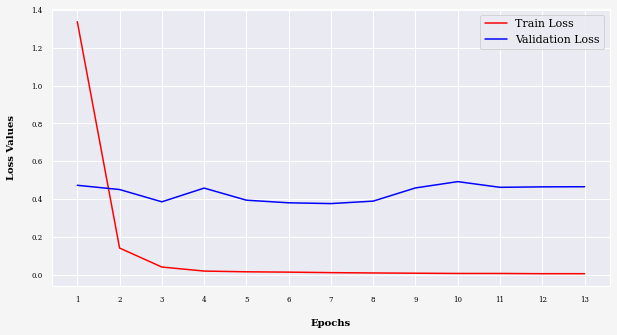

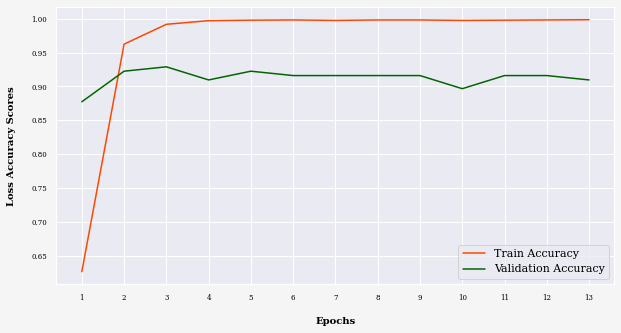

In [82]:
def learning_curves(tr_losses, val_losses, tr_accs, val_accs):

    plt.figure(figsize=(10, 5))
    plt.plot(tr_losses, label="Train Loss", c="red")
    plt.plot(val_losses, label="Validation Loss", c="blue")
    plt.xlabel("Epochs")
    plt.ylabel("Loss Values")
    plt.xticks(
        ticks=np.arange(len(tr_losses)),
        labels=[i for i in range(1, len(tr_losses) + 1)],
    )
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(tr_accs, label="Train Accuracy", c="orangered")
    plt.plot(val_accs, label="Validation Accuracy", c="darkgreen")
    plt.xlabel("Epochs")
    plt.ylabel("Loss Accuracy Scores")
    plt.xticks(
        ticks=np.arange(len(tr_accs)), labels=[i for i in range(1, len(tr_accs) + 1)]
    )
    plt.legend()
    plt.show()


learning_curves(
    acc_loss_dict['train_losses'], 
    acc_loss_dict['val_losses'], 
    acc_loss_dict['train_accs'], 
    acc_loss_dict['val_accs']
    )